# Adaptive Filters & Equalization

The need for adaptive equalization in the receive path of the can be summarized by the [MathWorks documentation on Equalization](https://www.mathworks.com/help/comm/ug/equalization.html):
>In a multipath fading scattering environment, the receiver typically detects several constantly changing, delayed versions of the transmitted signal. These time-dispersive channels cause intersymbol interference (ISI) that occurs when symbols received from multiple paths are delayed and overlap in time. ISI causes high error rates because the symbols from multiple received paths interfere with each other and become indistinguishable by the receiver.  

Equalizers attempt to mitigate ISI and improve the receiver performance. Equalizer structures are filters that attempt to match the propagation channel response. For time-varying propagation channels, adapting the equalization filter tap weights so that they maintain a match to the channel over time improves the error rate performance.

## Equalization Modes

There are two main modes of equalization operation: `FFE` or `DFE`. The decision on which mode to use is based on waveform impairments and computational complexity:

* `FFE` : Feed-Forward Equalization (FFE) is a linear adaptive filter which has the lowest computational complexity. It is useful for cleaning up received waveforms which have low Doppler speed and don’t have frequency-selective channel impairments. However, if a channel’s frequency response has nulls, a linear equalizer can increase noise, and `DFE` mode should be used instead.
* `DFE`: Decision Feedback Equalization (DFE) is an adaptive filter which computes weights based on error fed-back from a decision node, such as a demapper block. DFE mode can resolve frequency-selective channels as well as waveforms with higher Doppler speed, at the cost of increased computational complexity (compared to FFE).

### Equalization Algorithms

There are three main algorithms for adaptively computing filter weights:
* The Least Mean Square (LMS) algorithm executes quickly but converges slowly. Its complexity grows linearly with the number of weights.
* The Recursive Least Square (RLS) algorithm converges quickly. Its complexity grows approximately with the square of the number of weights. This algorithm can also be unstable when the number of weights is large.
* The constant modulus algorithm (CMA) is useful when no training signal is available. It works best for constant modulus modulations such as *M*-ary PSK.
    * **NOTE:** If CMA has no additional side information, it can introduce phase ambiguity. For example, the weights found by the CMA might produce a perfect QPSK constellation but introduce a phase rotation of 90, 180, or 270 degrees. In this case, employ a phase ambiguity correction algorithm or choose a differential modulation scheme. Differential modulation schemes are insensitive to phase ambiguity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from rfproto import filter, modulation, plot

## Blind Equalization via CMA

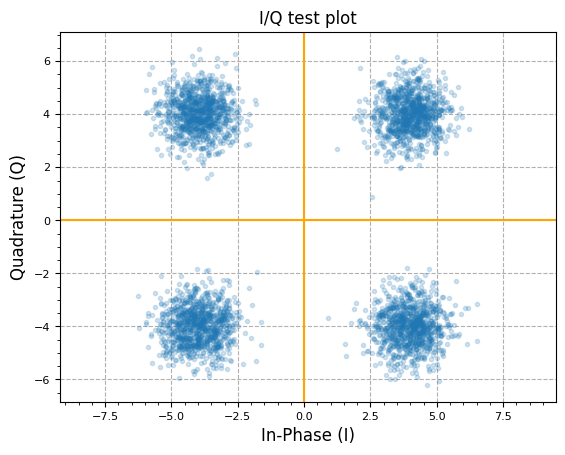

In [2]:
N = 4000
IQ_data = np.array([4 + 4j, -4 + 4j, -4 - 4j, 4 - 4j])
IQ_data = np.repeat(IQ_data, N // 4)
# similar to random.shuffle(IQ_data)
np.random.shuffle(IQ_data)
# Add AWGN with unity power
IQ_data += (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)
plot.IQ(IQ_data, "I/Q test plot", alpha=0.2)
plot.plt.show()

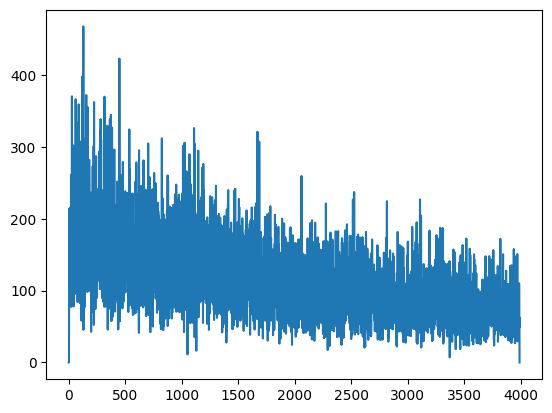

In [3]:
num_samples = len(IQ_data)
num_taps = 9
# adaptive filter taps
w = np.zeros(num_taps) + 1j*np.zeros(num_taps)
# start w/unity gain filter (passthrough)
w[num_taps//2] = 1.0 + 1j*0.0
# tapped delay line of input samples
u = np.zeros(num_taps) + 1j*np.zeros(num_taps)
# filter output
y = np.zeros(num_samples) + 1j*np.zeros(num_samples)
# CMA error vec
e = np.zeros(num_samples) + 1j*np.zeros(num_samples)
# desired modulus R = A^2, 
# so for I/Q amp = 1.0, mag = sqrt(2) = A, so A^2 = 2
#R = 2.0
R = 1.0
step_size = 0.0000001 #0.0001


for m in range(num_samples - num_taps):
#for m in range(10):
    # Shift input data in tapped delay line
    # Then Perform filter convolution (dot product) of adaptive weights and 
    #  tapped delay line of input samples
    for l in reversed(range(num_taps)):
        if not l:
            u[l] = IQ_data[m]
        else:
            u[l] = u[l-1]
        y[m] += w[l] * u[l]
    
    # CMA error calc
    # simplification of abs(y)^2
    y_mag = (np.real(y[m]) * np.real(y[m])) + (np.imag(y[m]) * np.imag(y[m]))
    e[m] = y[m] * (R - y_mag)

    # Innovate filter to compute new weights
    # NOTE: can also be batchified/averaged instead of computing new weights every cycle/sample
    for l in range(num_taps):
        w[l] += (step_size * np.conj(u[l]) * e[m])
        

plt.plot(abs(e[:-l]))
plt.show()

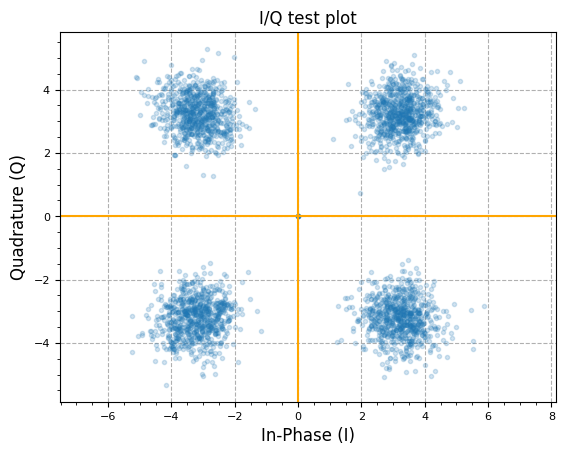

In [4]:
plot.IQ(y[1000:], "I/Q test plot", alpha=0.2)
plot.plt.show()

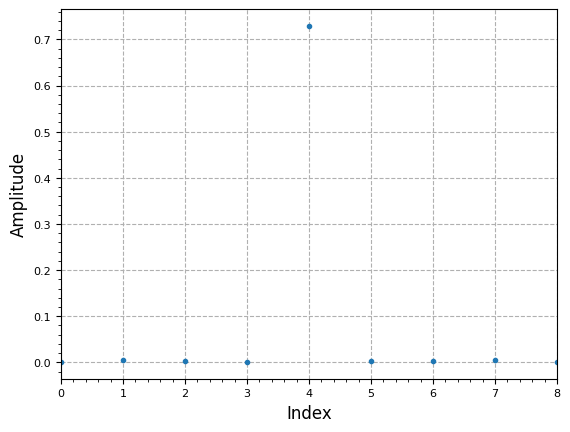

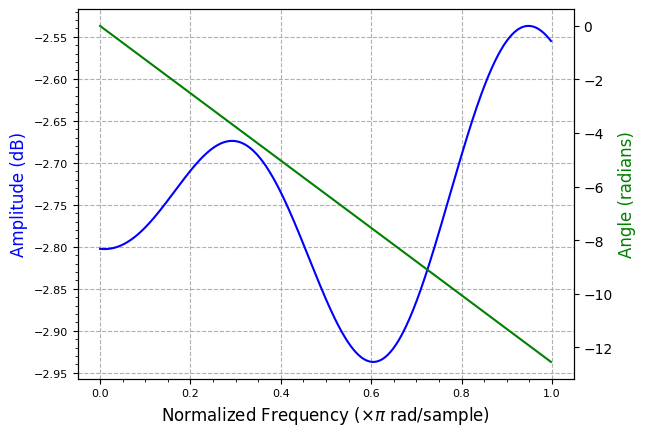

In [5]:
plot.filter_coefficients(np.abs(w))
plt.show()
plot.filter_response(w)
plt.show()

## References

* [Adaptive Equalizers - Mathworks](https://www.mathworks.com/help/comm/ug/adaptive-equalizers.html)
* [Blind Channel Equalization - Matlab File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/39482-blind-channel-equalization)
* [The multimodulus blind equalization and its generalized algorithms](https://ieeexplore.ieee.org/document/1007381)
* [Blind adaptive equalization for QAM signals: New algorithms and FPGA implementation.](https://scholar.uwindsor.ca/cgi/viewcontent.cgi?article=2311&context=etd)
* [Adaptive Equalization for SQPSK and SQPR Over Frequency Selective Microwave LOS Channels](https://ieeexplore.ieee.org/abstract/document/1096100)
* [How Decision Feedback Equalizers (DFE) Work](https://wirelesspi.com/how-decision-feedback-equalizers-dfe-work/)
* [AN ADAPTIVE BASEBAND EQUALIZER FOR HIGH DATA RATE BANDLIMITED CHANNELS](https://repository.arizona.edu/handle/10150/604050)
* [Least Mean-Squares Equalizer - Liquid SDR](https://liquidsdr.org/blog/lms-equalizer/)
* [Development of LMS Equalizer - DSP Stack Exchange](https://dsp.stackexchange.com/questions/31318/compensating-loudspeaker-frequency-response-in-an-audio-signal)
* [Least Squares Solution Using the DFT vs Wiener-Hopf Equations - DSP Stack Exchange](https://dsp.stackexchange.com/questions/87326/least-squares-solution-using-the-dft-vs-wiener-hopf-equations)
* [Fractionally Spaced Blind Equalizer Performance Improvement](https://vtechworks.lib.vt.edu/items/67ae7617-33bf-47d6-983c-f22cc5302845)